In [18]:
import os

base_dir = "/kaggle/input/plantvillage-dataset/color"

print(os.listdir(base_dir)[:20])  # voir quelques dossiers


['Tomato___Late_blight', 'Tomato___healthy', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Potato___healthy', 'Corn_(maize)___Northern_Leaf_Blight', 'Tomato___Early_blight', 'Tomato___Septoria_leaf_spot', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Strawberry___Leaf_scorch', 'Peach___healthy', 'Apple___Apple_scab', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Bacterial_spot', 'Apple___Black_rot', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Peach___Bacterial_spot']


**1) Récupérer toutes les images******

In [19]:
import os
import glob
import pandas as pd

base_dir = "/kaggle/input/plantvillage-dataset/color"

all_subdirs = os.listdir(base_dir)

# --- récupérer les dossiers par plante ---
tomato_dirs = [d for d in all_subdirs if d.startswith("Tomato")]
apple_dirs  = [d for d in all_subdirs if d.startswith("Apple")]
corn_dirs   = [d for d in all_subdirs if d.startswith("Corn")]
grape_dirs  = [d for d in all_subdirs if d.startswith("Grape")]

print("Tomate :", tomato_dirs)
print("Pomme :", apple_dirs)
print("Corn :", corn_dirs)
print("Grape :", grape_dirs)

def collect_paths(plant_dirs):
    paths = []
    for d in plant_dirs:
        paths += glob.glob(os.path.join(base_dir, d, "*.jpg"))
        paths += glob.glob(os.path.join(base_dir, d, "*.JPG"))
    return paths

# --- collecter les chemins des images ---
tomato_paths = collect_paths(tomato_dirs)
apple_paths  = collect_paths(apple_dirs)
corn_paths   = collect_paths(corn_dirs)
grape_paths  = collect_paths(grape_dirs)

print("Nb Tomate :", len(tomato_paths))
print("Nb Pomme :", len(apple_paths))
print("Nb Corn :", len(corn_paths))
print("Nb Grape :", len(grape_paths))

# --- créer le DataFrame ---
df_tomato = pd.DataFrame({"path": tomato_paths, "label": "tomato"})
df_apple  = pd.DataFrame({"path": apple_paths,  "label": "apple"})
df_corn   = pd.DataFrame({"path": corn_paths,   "label": "corn"})
df_grape  = pd.DataFrame({"path": grape_paths,  "label": "grape"})

df = pd.concat([df_tomato, df_apple, df_corn, df_grape], ignore_index=True)

df.head()

Tomate : ['Tomato___Late_blight', 'Tomato___healthy', 'Tomato___Early_blight', 'Tomato___Septoria_leaf_spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Bacterial_spot', 'Tomato___Target_Spot', 'Tomato___Tomato_mosaic_virus', 'Tomato___Leaf_Mold', 'Tomato___Spider_mites Two-spotted_spider_mite']
Pomme : ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy']
Corn : ['Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___healthy']
Grape : ['Grape___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)']
Nb Tomate : 18159
Nb Pomme : 3171
Nb Corn : 3852
Nb Grape : 4062


,path,label
0,/kaggle/input/plantvillage-dataset/color/Tomat...,tomato
1,/kaggle/input/plantvillage-dataset/color/Tomat...,tomato
2,/kaggle/input/plantvillage-dataset/color/Tomat...,tomato
3,/kaggle/input/plantvillage-dataset/color/Tomat...,tomato
4,/kaggle/input/plantvillage-dataset/color/Tomat...,tomato


Voir les classes présentes

In [20]:
print("Classes présentes dans le dataset :")
print(df["label"].unique())


Classes présentes dans le dataset :
['tomato' 'apple' 'corn' 'grape']


**2) Encoder les labels en nombres**

In [21]:
print(df["label"].value_counts())

label_to_id = {"tomato": 0, "apple": 1, "corn": 2, "grape": 3}
df["label_id"] = df["label"].map(label_to_id)

df[["path", "label", "label_id"]].head()


label
tomato    18159
grape      4062
corn       3852
apple      3171
Name: count, dtype: int64


,path,label,label_id
0,/kaggle/input/plantvillage-dataset/color/Tomat...,tomato,0
1,/kaggle/input/plantvillage-dataset/color/Tomat...,tomato,0
2,/kaggle/input/plantvillage-dataset/color/Tomat...,tomato,0
3,/kaggle/input/plantvillage-dataset/color/Tomat...,tomato,0
4,/kaggle/input/plantvillage-dataset/color/Tomat...,tomato,0


**3) Split train / validation (stratifié)**

In [22]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df["label_id"],
    random_state=42
)

print("Taille train :", len(train_df))
print("Taille val   :", len(val_df))

print("Répartition train :")
print(train_df["label"].value_counts())

print("\nRépartition val :")
print(val_df["label"].value_counts())



Taille train : 23395
Taille val   : 5849
Répartition train :
label
tomato    14527
grape      3249
corn       3082
apple      2537
Name: count, dtype: int64

Répartition val :
label
tomato    3632
grape      813
corn       770
apple      634
Name: count, dtype: int64


**4) TensorFlow (images → tenseurs)**
On lit l’image, on resize, on normalise, on retourne (image, label_id).

In [23]:
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

def decode_img(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    return img, label

def make_dataset(paths, labels, training=True):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if training:
        ds = ds.shuffle(buffer_size=len(paths))
    ds = ds.map(decode_img, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

train_ds = make_dataset(
    train_df["path"].values,
    train_df["label_id"].values,
    training=True
)

val_ds = make_dataset(
    val_df["path"].values,
    val_df["label_id"].values,
    training=False
)


**5) Définir le modèle CNN multi-classes**

In [24]:
from tensorflow.keras import layers, models

num_classes = 4  # tomato, apple, corn, grape

model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPool2D(),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPool2D(),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPool2D(),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')  # 4 classes
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # labels = 0,1,2,3
    metrics=['accuracy']
)

model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,245,700 (84.86 MB)

 Trainable params: 22,245,700 (84.86 MB)

 Non-trainable params: 0 (0.00 B)

**6) Entraîner le modèle**

In [25]:
EPOCHS = 5  # tu peux augmenter après si ça marche bien

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS 
)


Epoch 1/5
732/732 ━━━━━━━━━━━━━━━━━━━━ 1497s 2s/step - accuracy: 0.8093 - loss: 0.5954 - val_accuracy: 0.9439 - val_loss: 0.1515
Epoch 2/5
732/732 ━━━━━━━━━━━━━━━━━━━━ 1475s 2s/step - accuracy: 0.9436 - loss: 0.1611 - val_accuracy: 0.9660 - val_loss: 0.1026
Epoch 3/5
732/732 ━━━━━━━━━━━━━━━━━━━━ 1514s 2s/step - accuracy: 0.9649 - loss: 0.0958 - val_accuracy: 0.9672 - val_loss: 0.0847
Epoch 4/5
732/732 ━━━━━━━━━━━━━━━━━━━━ 1470s 2s/step - accuracy: 0.9663 - loss: 0.0971 - val_accuracy: 0.9822 - val_loss: 0.0531
Epoch 5/5
732/732 ━━━━━━━━━━━━━━━━━━━━ 1573s 2s/step - accuracy: 0.9838 - loss: 0.0465 - val_accuracy: 0.9762 - val_loss: 0.0658


In [29]:
model.save("/kaggle/working/model_plant.h5")

Test

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
Vraie classe : tomato
Prédiction  : tomato
Scores softmax : [9.9857152e-01 1.4198424e-03 2.5496884e-06 6.0688499e-06]


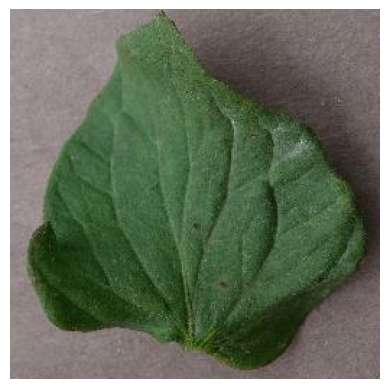

In [30]:
import numpy as np
import matplotlib.pyplot as plt

id_to_label = {0: "tomato", 1: "apple", 2: "corn", 3: "grape"}

# choisir une image au hasard dans la validation
sample = val_df.sample(1).iloc[0]
img_path = sample["path"]
true_id = sample["label_id"]

# charger l'image
img = tf.io.read_file(img_path)
img = tf.image.decode_jpeg(img, channels=3)
img_resized = tf.image.resize(img, IMG_SIZE)
img_norm = tf.cast(img_resized, tf.float32) / 255.0

# prédiction (softmax -> 4 probabilités)
pred = model.predict(tf.expand_dims(img_norm, axis=0))[0]
pred_id = int(tf.argmax(pred))
pred_label = id_to_label[pred_id]

print("Vraie classe :", id_to_label[true_id])
print("Prédiction  :", pred_label)
print("Scores softmax :", pred)

plt.imshow(img.numpy().astype("uint8"))
plt.axis("off")
plt.show()


In [31]:
import os
import glob
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

base_dir = "/kaggle/input/plantvillage-dataset/color"


** Récupérer UNIQUEMENT les dossiers TOMATO**

In [32]:
tomato_dirs = [d for d in os.listdir(base_dir) if d.startswith("Tomato")]
print("Classes Tomate :", tomato_dirs)


Classes Tomate : ['Tomato___Late_blight', 'Tomato___healthy', 'Tomato___Early_blight', 'Tomato___Septoria_leaf_spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Bacterial_spot', 'Tomato___Target_Spot', 'Tomato___Tomato_mosaic_virus', 'Tomato___Leaf_Mold', 'Tomato___Spider_mites Two-spotted_spider_mite']


Créer le DataFrame

In [33]:
data = []

for d in tomato_dirs:
    disease = d.replace("Tomato___", "")   # nom de la maladie
    img_paths = glob.glob(os.path.join(base_dir, d, "*.jpg"))
    img_paths += glob.glob(os.path.join(base_dir, d, "*.JPG"))

    for p in img_paths:
        data.append({
            "path": p,
            "disease": disease
        })

df_tomato = pd.DataFrame(data)

print("Nombre total d'images :", len(df_tomato))
print("Maladies Tomate :", df_tomato["disease"].unique())

df_tomato.head()


Nombre total d'images : 18159
Maladies Tomate : ['Late_blight' 'healthy' 'Early_blight' 'Septoria_leaf_spot'
 'Tomato_Yellow_Leaf_Curl_Virus' 'Bacterial_spot' 'Target_Spot'
 'Tomato_mosaic_virus' 'Leaf_Mold' 'Spider_mites Two-spotted_spider_mite']


,path,disease
0,/kaggle/input/plantvillage-dataset/color/Tomat...,Late_blight
1,/kaggle/input/plantvillage-dataset/color/Tomat...,Late_blight
2,/kaggle/input/plantvillage-dataset/color/Tomat...,Late_blight
3,/kaggle/input/plantvillage-dataset/color/Tomat...,Late_blight
4,/kaggle/input/plantvillage-dataset/color/Tomat...,Late_blight


Encoder les maladies

In [34]:
# liste des maladies
disease_names = sorted(df_tomato["disease"].unique())
print("Classes maladies :", disease_names)

disease_to_id = {name: i for i, name in enumerate(disease_names)}
id_to_disease = {i: name for name, i in disease_to_id.items()}

df_tomato["label_id"] = df_tomato["disease"].map(disease_to_id)

df_tomato.head()


Classes maladies : ['Bacterial_spot', 'Early_blight', 'Late_blight', 'Leaf_Mold', 'Septoria_leaf_spot', 'Spider_mites Two-spotted_spider_mite', 'Target_Spot', 'Tomato_Yellow_Leaf_Curl_Virus', 'Tomato_mosaic_virus', 'healthy']


,path,disease,label_id
0,/kaggle/input/plantvillage-dataset/color/Tomat...,Late_blight,2
1,/kaggle/input/plantvillage-dataset/color/Tomat...,Late_blight,2
2,/kaggle/input/plantvillage-dataset/color/Tomat...,Late_blight,2
3,/kaggle/input/plantvillage-dataset/color/Tomat...,Late_blight,2
4,/kaggle/input/plantvillage-dataset/color/Tomat...,Late_blight,2


Split train / validation

In [35]:
train_df, val_df = train_test_split(
    df_tomato,
    test_size=0.2,
    stratify=df_tomato["label_id"],
    random_state=42
)

print("Train :", len(train_df))
print("Validation :", len(val_df))


Train : 14527
Validation : 3632


TensorFlow

In [36]:
def decode_img(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    return img, label

def make_dataset(df, training=True):
    ds = tf.data.Dataset.from_tensor_slices(
        (df["path"].values, df["label_id"].values)
    )
    if training:
        ds = ds.shuffle(len(df))
    ds = ds.map(decode_img, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

train_ds = make_dataset(train_df, training=True)
val_ds   = make_dataset(val_df, training=False)


Créer le modèle CNN (maladies TOMATO)

In [37]:
num_classes = len(disease_names)

model_tomato_disease = models.Sequential([
    layers.Input(shape=(224, 224, 3)),

    layers.Conv2D(32, 3, activation="relu"),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, activation="relu"),
    layers.MaxPooling2D(),

    layers.Conv2D(128, 3, activation="relu"),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.5),

    layers.Dense(num_classes, activation="softmax")
])

model_tomato_disease.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model_tomato_disease.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,247,242 (84.87 MB)

 Trainable params: 22,247,242 (84.87 MB)

 Non-trainable params: 0 (0.00 B)

Entraîner le modèle TOMATO

In [38]:
EPOCHS = 5

history_tomato = model_tomato_disease.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)


Epoch 1/5
454/454 ━━━━━━━━━━━━━━━━━━━━ 946s 2s/step - accuracy: 0.5605 - loss: 1.3334 - val_accuracy: 0.8142 - val_loss: 0.5136
Epoch 2/5
454/454 ━━━━━━━━━━━━━━━━━━━━ 920s 2s/step - accuracy: 0.8304 - loss: 0.5092 - val_accuracy: 0.9075 - val_loss: 0.2635
Epoch 3/5
454/454 ━━━━━━━━━━━━━━━━━━━━ 917s 2s/step - accuracy: 0.8823 - loss: 0.3405 - val_accuracy: 0.9001 - val_loss: 0.2890
Epoch 4/5
454/454 ━━━━━━━━━━━━━━━━━━━━ 913s 2s/step - accuracy: 0.9111 - loss: 0.2619 - val_accuracy: 0.8995 - val_loss: 0.2784
Epoch 5/5
454/454 ━━━━━━━━━━━━━━━━━━━━ 906s 2s/step - accuracy: 0.9302 - loss: 0.2170 - val_accuracy: 0.9416 - val_loss: 0.1730


In [39]:
model_tomato_disease.save("/kaggle/working/tomato_disease.keras")

Tester le modèle (maladie tomate)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
Vraie maladie : Late_blight
Maladie prédite : Late_blight


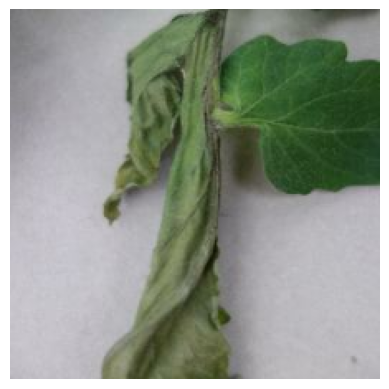

In [40]:
import numpy as np
import matplotlib.pyplot as plt

sample = val_df.sample(1).iloc[0]

img = tf.io.read_file(sample["path"])
img = tf.image.decode_jpeg(img, channels=3)
img = tf.image.resize(img, IMG_SIZE)
img = tf.cast(img, tf.float32) / 255.0

pred = model_tomato_disease.predict(tf.expand_dims(img, axis=0))[0]
pred_id = np.argmax(pred)

print("Vraie maladie :", sample["disease"])
print("Maladie prédite :", id_to_disease[pred_id])

plt.imshow(img.numpy())
plt.axis("off")
plt.show()


 Entraîner le modèle de maladie APPLE

In [42]:
import os
import glob
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

base_dir = "/kaggle/input/plantvillage-dataset/color"


Récupérer UNIQUEMENT les dossiers APPLE

In [43]:
apple_dirs = [d for d in os.listdir(base_dir) if d.startswith("Apple")]
print("Classes Apple :", apple_dirs)


Classes Apple : ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy']


Créer le DataFrame

In [44]:
data = []

for d in apple_dirs:
    disease = d.replace("Apple___", "")
    img_paths = glob.glob(os.path.join(base_dir, d, "*.jpg"))
    img_paths += glob.glob(os.path.join(base_dir, d, "*.JPG"))

    for p in img_paths:
        data.append({
            "path": p,
            "disease": disease
        })

df_apple = pd.DataFrame(data)

print("Nombre total d'images :", len(df_apple))
print("Maladies Apple :", df_apple["disease"].unique())

df_apple.head()


Nombre total d'images : 3171
Maladies Apple : ['Apple_scab' 'Black_rot' 'Cedar_apple_rust' 'healthy']


,path,disease
0,/kaggle/input/plantvillage-dataset/color/Apple...,Apple_scab
1,/kaggle/input/plantvillage-dataset/color/Apple...,Apple_scab
2,/kaggle/input/plantvillage-dataset/color/Apple...,Apple_scab
3,/kaggle/input/plantvillage-dataset/color/Apple...,Apple_scab
4,/kaggle/input/plantvillage-dataset/color/Apple...,Apple_scab


Encoder les maladies

In [45]:
disease_names = sorted(df_apple["disease"].unique())
print("Classes maladies Apple :", disease_names)

disease_to_id = {name: i for i, name in enumerate(disease_names)}
id_to_disease = {i: name for name, i in disease_to_id.items()}

df_apple["label_id"] = df_apple["disease"].map(disease_to_id)

df_apple.head()


Classes maladies Apple : ['Apple_scab', 'Black_rot', 'Cedar_apple_rust', 'healthy']


,path,disease,label_id
0,/kaggle/input/plantvillage-dataset/color/Apple...,Apple_scab,0
1,/kaggle/input/plantvillage-dataset/color/Apple...,Apple_scab,0
2,/kaggle/input/plantvillage-dataset/color/Apple...,Apple_scab,0
3,/kaggle/input/plantvillage-dataset/color/Apple...,Apple_scab,0
4,/kaggle/input/plantvillage-dataset/color/Apple...,Apple_scab,0


Split train / validation

In [46]:
train_df, val_df = train_test_split(
    df_apple,
    test_size=0.2,
    stratify=df_apple["label_id"],
    random_state=42
)

print("Train :", len(train_df))
print("Validation :", len(val_df))


Train : 2536
Validation : 635


TensorFlow

In [47]:
def decode_img(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    return img, label

def make_dataset(df, training=True):
    ds = tf.data.Dataset.from_tensor_slices(
        (df["path"].values, df["label_id"].values)
    )
    if training:
        ds = ds.shuffle(len(df))
    ds = ds.map(decode_img, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

train_ds = make_dataset(train_df, training=True)
val_ds   = make_dataset(val_df, training=False)


Créer le modèle CNN 

In [48]:
num_classes = len(disease_names)

model_apple_disease = models.Sequential([
    layers.Input(shape=(224, 224, 3)),

    layers.Conv2D(32, 3, activation="relu"),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, activation="relu"),
    layers.MaxPooling2D(),

    layers.Conv2D(128, 3, activation="relu"),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.5),

    layers.Dense(num_classes, activation="softmax")
])

model_apple_disease.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model_apple_disease.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,245,700 (84.86 MB)

 Trainable params: 22,245,700 (84.86 MB)

 Non-trainable params: 0 (0.00 B)

Entraîner le modèle APPLE

In [49]:
EPOCHS = 5

history_apple = model_apple_disease.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)


Epoch 1/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 162s 2s/step - accuracy: 0.6029 - loss: 1.0965 - val_accuracy: 0.8898 - val_loss: 0.3436
Epoch 2/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 160s 2s/step - accuracy: 0.8775 - loss: 0.3395 - val_accuracy: 0.8000 - val_loss: 0.4644
Epoch 3/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 170s 2s/step - accuracy: 0.8797 - loss: 0.3004 - val_accuracy: 0.8835 - val_loss: 0.3298
Epoch 4/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 158s 2s/step - accuracy: 0.9221 - loss: 0.2183 - val_accuracy: 0.8693 - val_loss: 0.3426
Epoch 5/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 158s 2s/step - accuracy: 0.9259 - loss: 0.1904 - val_accuracy: 0.9465 - val_loss: 0.1716


In [50]:
model_apple_disease.save("/kaggle/working/apple_disease.keras")

Tester le modèle

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
Vraie maladie : Black_rot
Maladie prédite : Black_rot


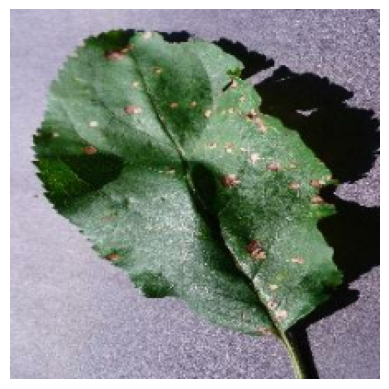

In [51]:
sample = val_df.sample(1).iloc[0]

img = tf.io.read_file(sample["path"])
img = tf.image.decode_jpeg(img, channels=3)
img = tf.image.resize(img, IMG_SIZE)
img = tf.cast(img, tf.float32) / 255.0

pred = model_apple_disease.predict(tf.expand_dims(img, axis=0))[0]
pred_id = np.argmax(pred)

print("Vraie maladie :", sample["disease"])
print("Maladie prédite :", id_to_disease[pred_id])

plt.imshow(img.numpy())
plt.axis("off")
plt.show()


Entraîner le modèle de maladie CORN

In [52]:
import os
import glob
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

base_dir = "/kaggle/input/plantvillage-dataset/color"


Récupérer UNIQUEMENT les dossiers CORN

In [53]:
corn_dirs = [d for d in os.listdir(base_dir) if d.startswith("Corn")]
print("Classes Corn :", corn_dirs)


Classes Corn : ['Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___healthy']


Créer le DataFrame

In [55]:
data = []

for d in corn_dirs:
    disease = d.replace("Corn_(maize)___", "")
    img_paths = glob.glob(os.path.join(base_dir, d, "*.jpg"))
    img_paths += glob.glob(os.path.join(base_dir, d, "*.JPG"))

    for p in img_paths:
        data.append({
            "path": p,
            "disease": disease
        })

df_corn = pd.DataFrame(data)

print("Nombre total d'images :", len(df_corn))
print("Maladies Corn :", df_corn["disease"].unique())

df_corn.head()


Nombre total d'images : 3852
Maladies Corn : ['Northern_Leaf_Blight' 'Cercospora_leaf_spot Gray_leaf_spot'
 'Common_rust_' 'healthy']


,path,disease
0,/kaggle/input/plantvillage-dataset/color/Corn_...,Northern_Leaf_Blight
1,/kaggle/input/plantvillage-dataset/color/Corn_...,Northern_Leaf_Blight
2,/kaggle/input/plantvillage-dataset/color/Corn_...,Northern_Leaf_Blight
3,/kaggle/input/plantvillage-dataset/color/Corn_...,Northern_Leaf_Blight
4,/kaggle/input/plantvillage-dataset/color/Corn_...,Northern_Leaf_Blight


 Encoder les maladies

In [56]:
disease_names = sorted(df_corn["disease"].unique())
print("Classes maladies Corn :", disease_names)

disease_to_id = {name: i for i, name in enumerate(disease_names)}
id_to_disease = {i: name for name, i in disease_to_id.items()}

df_corn["label_id"] = df_corn["disease"].map(disease_to_id)

df_corn.head()


Classes maladies Corn : ['Cercospora_leaf_spot Gray_leaf_spot', 'Common_rust_', 'Northern_Leaf_Blight', 'healthy']


,path,disease,label_id
0,/kaggle/input/plantvillage-dataset/color/Corn_...,Northern_Leaf_Blight,2
1,/kaggle/input/plantvillage-dataset/color/Corn_...,Northern_Leaf_Blight,2
2,/kaggle/input/plantvillage-dataset/color/Corn_...,Northern_Leaf_Blight,2
3,/kaggle/input/plantvillage-dataset/color/Corn_...,Northern_Leaf_Blight,2
4,/kaggle/input/plantvillage-dataset/color/Corn_...,Northern_Leaf_Blight,2


Split train / validation

In [57]:
train_df, val_df = train_test_split(
    df_corn,
    test_size=0.2,
    stratify=df_corn["label_id"],
    random_state=42
)

print("Train :", len(train_df))
print("Validation :", len(val_df))


Train : 3081
Validation : 771


TensorFlow

In [58]:
def decode_img(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    return img, label

def make_dataset(df, training=True):
    ds = tf.data.Dataset.from_tensor_slices(
        (df["path"].values, df["label_id"].values)
    )
    if training:
        ds = ds.shuffle(len(df))
    ds = ds.map(decode_img, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

train_ds = make_dataset(train_df, training=True)
val_ds   = make_dataset(val_df, training=False)


Créer le modèle CNN

In [59]:
num_classes = len(disease_names)

model_corn_disease = models.Sequential([
    layers.Input(shape=(224, 224, 3)),

    layers.Conv2D(32, 3, activation="relu"),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, activation="relu"),
    layers.MaxPooling2D(),

    layers.Conv2D(128, 3, activation="relu"),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.5),

    layers.Dense(num_classes, activation="softmax")
])

model_corn_disease.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model_corn_disease.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,245,700 (84.86 MB)

 Trainable params: 22,245,700 (84.86 MB)

 Non-trainable params: 0 (0.00 B)

Entraîner le modèle CORN

In [60]:
EPOCHS = 5

history_corn = model_corn_disease.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)


Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 194s 2s/step - accuracy: 0.6208 - loss: 0.9163 - val_accuracy: 0.8677 - val_loss: 0.2646
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 192s 2s/step - accuracy: 0.8591 - loss: 0.3053 - val_accuracy: 0.8846 - val_loss: 0.2295
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 198s 2s/step - accuracy: 0.8931 - loss: 0.2443 - val_accuracy: 0.8923 - val_loss: 0.2274
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 192s 2s/step - accuracy: 0.8992 - loss: 0.2295 - val_accuracy: 0.8677 - val_loss: 0.2955
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 191s 2s/step - accuracy: 0.8916 - loss: 0.2673 - val_accuracy: 0.9027 - val_loss: 0.1935


In [61]:
model_corn_disease.save("/kaggle/working/corn_disease.keras")

Tester le modèle (maladie Corn)

Chemin : /kaggle/input/plantvillage-dataset/color/Corn_(maize)___healthy/85581bfb-0508-4cea-a76c-b929fea867a1___R.S_HL 0605 copy 2.jpg
Vraie maladie : healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
Maladie prédite : healthy


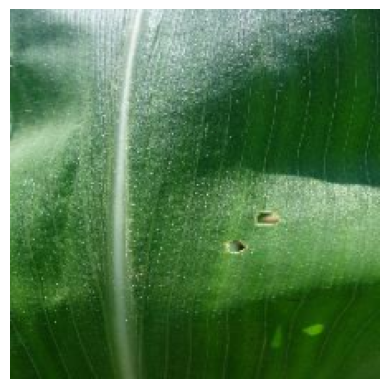

In [62]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# 1️⃣ Choisir une image AU HASARD
sample = val_df.sample(1).iloc[0]

print("Chemin :", sample["path"])
print("Vraie maladie :", sample["disease"])

# 2️⃣ Charger et prétraiter l'image
img = tf.io.read_file(sample["path"])
img = tf.image.decode_jpeg(img, channels=3)
img = tf.image.resize(img, IMG_SIZE)
img = tf.cast(img, tf.float32) / 255.0

# 3️⃣ Prédiction
pred = model_corn_disease.predict(tf.expand_dims(img, axis=0))[0]
pred_id = np.argmax(pred)

print("Maladie prédite :", id_to_disease[pred_id])

# 4️⃣ Affichage
plt.imshow(img.numpy())
plt.axis("off")
plt.show()


Récupérer UNIQUEMENT les dossiers GRAPE

In [63]:
grape_dirs = [d for d in os.listdir(base_dir) if d.startswith("Grape")]
print("Classes Grape :", grape_dirs)


Classes Grape : ['Grape___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)']


Créer le DataFrame

In [65]:
data = []

for d in grape_dirs:
    disease = d.replace("Grape___", "")
    img_paths = glob.glob(os.path.join(base_dir, d, "*.jpg"))
    img_paths += glob.glob(os.path.join(base_dir, d, "*.JPG"))

    for p in img_paths:
        data.append({
            "path": p,
            "disease": disease
        })

df_grape = pd.DataFrame(data)

print("Nombre total d'images :", len(df_grape))
print("Maladies Grape :", df_grape["disease"].unique())

df_grape.head()


Nombre total d'images : 4062
Maladies Grape : ['healthy' 'Leaf_blight_(Isariopsis_Leaf_Spot)' 'Black_rot'
 'Esca_(Black_Measles)']


,path,disease
0,/kaggle/input/plantvillage-dataset/color/Grape...,healthy
1,/kaggle/input/plantvillage-dataset/color/Grape...,healthy
2,/kaggle/input/plantvillage-dataset/color/Grape...,healthy
3,/kaggle/input/plantvillage-dataset/color/Grape...,healthy
4,/kaggle/input/plantvillage-dataset/color/Grape...,healthy


Encoder les maladies (labels numériques)

In [66]:
disease_names = sorted(df_grape["disease"].unique())
print("Classes maladies Grape :", disease_names)

disease_to_id = {name: i for i, name in enumerate(disease_names)}
id_to_disease = {i: name for name, i in disease_to_id.items()}

df_grape["label_id"] = df_grape["disease"].map(disease_to_id)

df_grape.head()


Classes maladies Grape : ['Black_rot', 'Esca_(Black_Measles)', 'Leaf_blight_(Isariopsis_Leaf_Spot)', 'healthy']


,path,disease,label_id
0,/kaggle/input/plantvillage-dataset/color/Grape...,healthy,3
1,/kaggle/input/plantvillage-dataset/color/Grape...,healthy,3
2,/kaggle/input/plantvillage-dataset/color/Grape...,healthy,3
3,/kaggle/input/plantvillage-dataset/color/Grape...,healthy,3
4,/kaggle/input/plantvillage-dataset/color/Grape...,healthy,3


Split train / validation

In [67]:
train_df, val_df = train_test_split(
    df_grape,
    test_size=0.2,
    stratify=df_grape["label_id"],
    random_state=42
)

print("Train :", len(train_df))
print("Validation :", len(val_df))


Train : 3249
Validation : 813


TensorFlow

In [68]:
def decode_img(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    return img, label

def make_dataset(df, training=True):
    ds = tf.data.Dataset.from_tensor_slices(
        (df["path"].values, df["label_id"].values)
    )
    if training:
        ds = ds.shuffle(len(df))
    ds = ds.map(decode_img, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

train_ds = make_dataset(train_df, training=True)
val_ds   = make_dataset(val_df, training=False)


Créer le modèle CNN (maladies GRAPE)

In [69]:
num_classes = len(disease_names)

model_grape_disease = models.Sequential([
    layers.Input(shape=(224, 224, 3)),

    layers.Conv2D(32, 3, activation="relu"),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, activation="relu"),
    layers.MaxPooling2D(),

    layers.Conv2D(128, 3, activation="relu"),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.5),

    layers.Dense(num_classes, activation="softmax")
])

model_grape_disease.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model_grape_disease.summary()


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,245,700 (84.86 MB)

 Trainable params: 22,245,700 (84.86 MB)

 Non-trainable params: 0 (0.00 B)

Entraîner le modèle GRAPE

In [70]:
EPOCHS = 5

history_grape = model_grape_disease.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)


Epoch 1/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 209s 2s/step - accuracy: 0.4617 - loss: 1.6514 - val_accuracy: 0.8672 - val_loss: 0.4825
Epoch 2/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 269s 2s/step - accuracy: 0.8528 - loss: 0.3866 - val_accuracy: 0.8991 - val_loss: 0.2411
Epoch 3/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 208s 2s/step - accuracy: 0.9102 - loss: 0.2305 - val_accuracy: 0.9274 - val_loss: 0.1925
Epoch 4/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 262s 2s/step - accuracy: 0.9503 - loss: 0.1423 - val_accuracy: 0.8991 - val_loss: 0.2411
Epoch 5/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 263s 2s/step - accuracy: 0.9560 - loss: 0.1274 - val_accuracy: 0.9250 - val_loss: 0.1945


In [71]:
model_grape_disease.save("/kaggle/working/grape_disease.keras")

Tester le modèle (maladie Grape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Vraie maladie : Esca_(Black_Measles)
Maladie prédite : Esca_(Black_Measles)


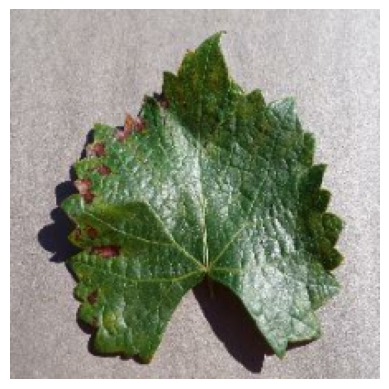

In [73]:
sample = val_df.sample(1).iloc[0]

img = tf.io.read_file(sample["path"])
img = tf.image.decode_jpeg(img, channels=3)
img = tf.image.resize(img, IMG_SIZE)
img = tf.cast(img, tf.float32) / 255.0

pred = model_grape_disease.predict(tf.expand_dims(img, axis=0))[0]
pred_id = np.argmax(pred)

print("Vraie maladie :", sample["disease"])
print("Maladie prédite :", id_to_disease[pred_id])

plt.imshow(img.numpy())
plt.axis("off")
plt.show()


In [74]:
import tensorflow as tf
from tensorflow.keras import layers, models

IMG_SIZE = (224,224)

model_plant = models.Sequential([
    layers.Input(shape=(224,224,3)),
    layers.Conv2D(32, 3, activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation="relu"),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dense(4, activation="softmax")  # 4 plantes
])

model_plant.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model_plant.summary()


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,476 (42.61 MB)

 Trainable params: 11,169,476 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [75]:
!ls /kaggle/working


apple_disease.keras  grape_disease.keras  tomato_disease.keras
corn_disease.keras   model_plant.h5


In [76]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model


PARAMÈTRES GLOBAUX

In [77]:
IMG_SIZE = (224, 224)

plant_classes = ["tomato", "apple", "corn", "grape"]


CHARGER TOUS LES MODÈLES

In [78]:
# 🌱 Modèle plante
model = load_model("/kaggle/working/model_plant.h5")

# 🦠 Modèles maladies
model_tomato_disease = load_model("/kaggle/working/tomato_disease.keras")
model_apple_disease  = load_model("/kaggle/working/apple_disease.keras")
model_corn_disease   = load_model("/kaggle/working/corn_disease.keras")
model_grape_disease  = load_model("/kaggle/working/grape_disease.keras")

print("✅ Tous les modèles chargés")


✅ Tous les modèles chargés


MAPPINGS DES MALADIES

In [79]:
id_to_disease_tomato = {
    0: "Bacterial_spot",
    1: "Early_blight",
    2: "Late_blight",
    3: "Leaf_Mold",
    4: "Septoria_leaf_spot",
    5: "Spider_mites",
    6: "Target_Spot",
    7: "Tomato_Yellow_Leaf_Curl_Virus",
    8: "Tomato_mosaic_virus",
    9: "healthy"
}

id_to_disease_apple = {
    0: "Apple_scab",
    1: "Black_rot",
    2: "Cedar_apple_rust",
    3: "healthy"
}

id_to_disease_corn = {
    0: "Cercospora_leaf_spot",
    1: "Common_rust",
    2: "Northern_Leaf_Blight",
    3: "healthy"
}

id_to_disease_grape = {
    0: "Black_rot",
    1: "Esca",
    2: "Leaf_blight",
    3: "healthy"
}


FONCTION DE PRÉTRAITEMENT IMAGE

In [81]:
def load_and_preprocess_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    return tf.expand_dims(img, axis=0)


In [82]:
def predict_plant_and_disease(img_path):
    img = load_and_preprocess_image(img_path)

    # 🌱 PRÉDICTION PLANTE
    plant_pred = model_plant.predict(img)[0]
    plant_id = np.argmax(plant_pred)
    plant_name = plant_classes[plant_id]

    print("🌱 Plante détectée :", plant_name)

    # 🦠 PRÉDICTION MALADIE
    if plant_name == "tomato":
        pred = model_tomato_disease.predict(img)[0]
        disease = id_to_disease_tomato[np.argmax(pred)]

    elif plant_name == "apple":
        pred = model_apple_disease.predict(img)[0]
        disease = id_to_disease_apple[np.argmax(pred)]

    elif plant_name == "corn":
        pred = model_corn_disease.predict(img)[0]
        disease = id_to_disease_corn[np.argmax(pred)]

    elif plant_name == "grape":
        pred = model_grape_disease.predict(img)[0]
        disease = id_to_disease_grape[np.argmax(pred)]

    else:
        disease = "Unknown"

    print("🦠 Maladie prédite :", disease)

    # 🖼️ Afficher image
    plt.imshow(tf.squeeze(img))
    plt.axis("off")
    plt.show()

    return plant_name, disease


TEST FINAL

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
🌱 Plante détectée : apple
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
🦠 Maladie prédite : Cedar_apple_rust


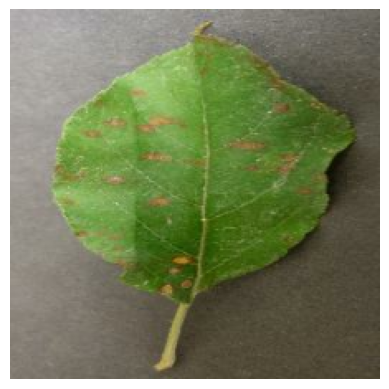

('apple', 'Cedar_apple_rust')

In [90]:
test_image = "/kaggle/input/plantvillage-dataset/color/Apple___Cedar_apple_rust/025b2b9a-0ec4-4132-96ac-7f2832d0db4a___FREC_C.Rust 3655.JPG"
predict_plant_and_disease(test_image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
🌱 Plante détectée : grape
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
🦠 Maladie prédite : Black_rot


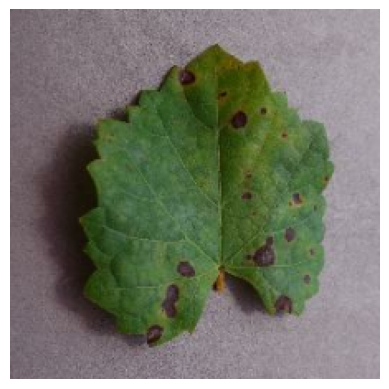

('grape', 'Black_rot')

In [92]:
test_image = "/kaggle/input/plantvillage-dataset/color/Grape___Black_rot/00090b0f-c140-4e77-8d20-d39f67b75fcc___FAM_B.Rot 0376.JPG"
predict_plant_and_disease(test_image)